##### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Machine Bottleneck

This notebook demonstrates the formulation and solution of the a machine bottleneck problem using GLPK/Mathprog. The task is to schedule a set of jobs on a single machine given the release time, duration, and due time for each job. Date for the example problem is from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000.

* [MathProg Model](#MathProg-Model)
* [Example](#Example)
* [Visualization](#Visualization)
* [Solution using Gurobi](#Gurobi)

## MathProg Model

The model uses a 'Big M' implementation of disjunctive constraints to avoid conflicts for a single machine.  Big M should be larger than the longest time horizon for the completion of all jobs. A bound on the longest horizon is the maximum release plus the sum of durations for all jobs.

In [1]:
%%writefile Bottleneck.mod

/* Machine Bottleneck Example */

set JOBS;

param rel{JOBS} default 0;   # Time a job is available to the machine
param dur{JOBS};             # Job duration
param due{JOBS};             # Job due time

/* Data Checks */
check {k in JOBS}: rel[k] + dur[k] <= due[k];

/* The model uses a 'Big M' implementation of disjunctive constraints
to avoid conflicts for a single machine.  Big M should be larger than
the longest time horizon for the completion of all jobs. A bound
on the longest horizon is the maximum release plus the sum of
durations for all jobs. */

param BigM := (max {k in JOBS} rel[k] ) + sum{k in JOBS} dur[k];

/* Decision variables are the start times for each job, and a
disjunctive variable y[j,k] which is 1 if job j precedes job k on
the machine. */

var start{JOBS} >= 0;
var pastdue{JOBS} >= 0;
var y{JOBS,JOBS} binary;

/* There are many possible objectives, including total pastdue, maximum
pastdue (i.e., tardiness), number of jobs pastdue.  */

minimize OBJ : sum {k in JOBS} pastdue[k];

/* Order Constraints */

s.t. START {k in JOBS}: start[k] >= rel[k];
s.t. FINIS {k in JOBS}: start[k] + dur[k] <= due[k] + pastdue[k];

/* Machine Conflict Constraints */

s.t. DA {j in JOBS, k in JOBS : j < k}:
   start[j] + dur[j] <= start[k] + BigM*(1-y[j,k]);
s.t. DB {j in JOBS, k in JOBS : j < k}:
   start[k] + dur[k] <= start[j] + BigM*y[j,k];

solve;

/* Create Tables */

table tout {k in JOBS} OUT "CSV" "Schedule.csv" "table":
    k~Job, rel[k]~Release, start[k]~Start, start[k]+dur[k]~Finish, due[k]~Due;

/* Print Report */

printf " Task     Rel     Dur     Due   Start  Finish Pastdue\n";
printf {k in JOBS} "%5s %7g %7g %7g %7g %7g %7g\n",
   k,rel[k],dur[k],due[k],start[k],start[k]+dur[k],pastdue[k];

end;

Overwriting Bottleneck.mod


## Example

Machine Bottleneck Example from Christelle Gueret, Christian Prins,
Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5,
Dash Optimization, 2000.

In [2]:
%%script glpsol -m Bottleneck.mod -d /dev/stdin -y results.txt --out output

param: JOBS : rel   dur   due :=
         A      2     5    10
         B      5     6    21
         C      4     8    15
         D      0     4    10
         E      0     2     5
         F      8     3    15
         G      9     2    22 ;

end;

In [3]:
print(open('results.txt').read())

 Task     Rel     Dur     Due   Start  Finish Pastdue
    A       2       5      10       6      11       1
    B       5       6      21      14      20       0
    C       4       8      15      22      30      15
    D       0       4      10       2       6       0
    E       0       2       5       0       2       0
    F       8       3      15      11      14       0
    G       9       2      22      20      22       0



In [4]:
import pandas
from IPython.display import display

schedule = pandas.read_csv("Schedule.csv")
display(schedule)

Job  Release  Start  Finish  Due
0   A        2      6      11   10
1   B        5     14      20   21
2   C        4     22      30   15
3   D        0      2       6   10
4   E        0      0       2    5
5   F        8     11      14   15
6   G        9     20      22   22

## Visualization

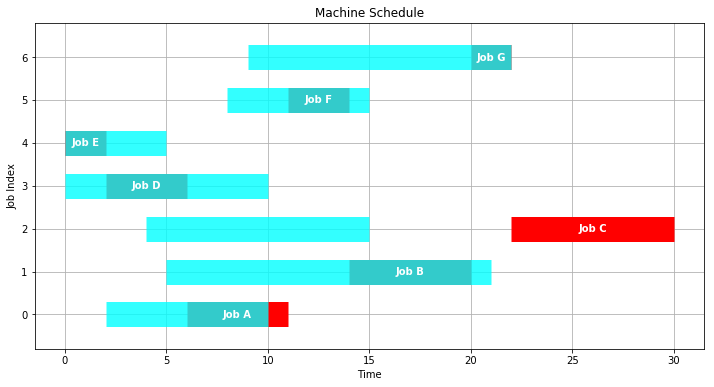

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
for i in schedule.index:
    plt.plot([schedule.ix[i,'Start'],schedule.ix[i,'Finish']],[i,i],
             color='red',alpha=1.0,lw=25,solid_capstyle="butt")
    plt.plot([schedule.ix[i,'Release'],schedule.ix[i,'Due']],[i,i],
             color='cyan',alpha=0.8,lw=25,solid_capstyle="butt")
    plt.text((schedule.ix[i,'Start']+schedule.ix[i,'Finish'])/2.0,i,
             'Job '+schedule.ix[i,'Job'],color='white',weight='bold',
            horizontalalignment='center',verticalalignment='center')

plt.ylim(plt.ylim()[0]-0.5,plt.ylim()[1]+0.5)
plt.title('Machine Schedule')
plt.xlabel('Time')
plt.ylabel('Job Index')
plt.grid()

<a id="Gurobi"></a>
## Solution using Gurobi

In [6]:
# job data is organized as a pandas data frame with the index consisting of jobs names,
# and with columns labeled 'release', 'duration', and 'due

%matplotlib inline

import pandas as pd
from gurobipy import *
import matplotlib.pyplot as plt

ids = pd.Series(['A','B','C','D','E','F','G'])
release = pd.Series([2,5,4,0,0,8,9])
duration = pd.Series([5,6,8,4,2,3,2])
due = pd.Series([10,21,15,10,5,15,22])

jobs = pd.concat([ids,release,duration,due],axis=1)
jobs.columns = ['ID','release','duration','due']
jobs

ID  release  duration  due
0  A        2         5   10
1  B        5         6   21
2  C        4         8   15
3  D        0         4   10
4  E        0         2    5
5  F        8         3   15
6  G        9         2   22

In [11]:
# create model
m = Model('machine scheduling')

# create decision variables for each job
start = pd.Series(m.addVars(jobs.index))
pastdue = pd.Series(m.addVars(jobs.index))
finish = pd.Series(m.addVars(jobs.index))

# add constraints on start, finish, and pastdue
m.addConstrs(start[k] >= jobs.ix[k,'release'] for k in jobs.index)
m.addConstrs(start[k] + jobs.ix[k,'duration'] == finish[k] for k in jobs.index)
m.addConstrs(finish[k] <= jobs.ix[k,'due'] + pastdue[k] for k in jobs.index)
    
# create a global makespan
makespan = m.addVar()
m.addConstrs(makespan >= finish[k] for k in jobs.index)

# create a max pastdue
maxpastdue = m.addVar()
m.addConstrs(maxpastdue >= pastdue[k] for k in jobs.index)

# disjunctive ordering constraints
M = 100
pairs = [(i,j) for i in start.index for j in start.index if i < j]
y = m.addVars(pairs,vtype=GRB.BINARY)
m.addConstrs(finish[i] <= start[j] + M*y[i,j] for (i,j) in pairs)
m.addConstrs(finish[j] <= start[i] + M*(1-y[i,j]) for (i,j) in pairs)
m.update()

# objective function
m.setObjective(sum(pastdue),GRB.MINIMIZE)
m.optimize()

Optimize a model with 77 rows, 44 columns and 189 nonzeros
Variable types: 23 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+02]
Presolve removed 28 rows and 9 columns
Presolve time: 0.00s
Presolved: 49 rows, 35 columns, 140 nonzeros
Variable types: 14 continuous, 21 integer (21 binary)

Root relaxation: objective 0.000000e+00, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    5          -    0.00000      -     -    0s
H    0     0                      30.0000000    0.00000   100%     -    0s
H    0     0                      27.0000000    0.00000   100%     -    0s
     0     0    0.00000    0    6   27.00000    0.00000   100%     -    0s
     0     0    0.00000    0    8   27.00000  

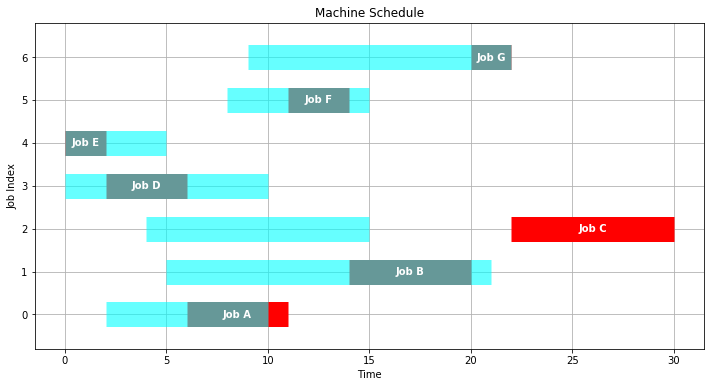

In [12]:
def visualize():
    plt.figure(figsize=(12,6))
    for i in jobs.index:
        plt.plot([start[i].X,finish[i].X],[i,i],
             color='red',alpha=1.0,lw=25,solid_capstyle="butt")
        plt.plot([release[i],due[i]],[i,i],
             color='cyan',alpha=0.6,lw=25,solid_capstyle="butt")
        plt.text((start[i].X + finish[i].X)/2.0,i,
            'Job ' + jobs.ix[i,'ID'], color='white', weight='bold',
            horizontalalignment='center', verticalalignment='center')

    plt.ylim(plt.ylim()[0]-0.5,plt.ylim()[1]+0.5)
    plt.title('Machine Schedule')
    plt.xlabel('Time')
    plt.ylabel('Job Index')
    plt.grid()

visualize()

Optimize a model with 77 rows, 44 columns and 189 nonzeros
Variable types: 23 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+02]
Presolve removed 28 rows and 15 columns
Presolve time: 0.00s
Presolved: 49 rows, 29 columns, 140 nonzeros

Loaded MIP start with objective 15

Variable types: 8 continuous, 21 integer (21 binary)

Root relaxation: objective 0.000000e+00, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    4   15.00000    0.00000   100%     -    0s
H    0     0                      14.0000000    0.00000   100%     -    0s
H    0     0                      10.0000000    0.00000   100%     -    0s
H    0     0                       9.0000000    0.00000   100%     -    0s
     0   

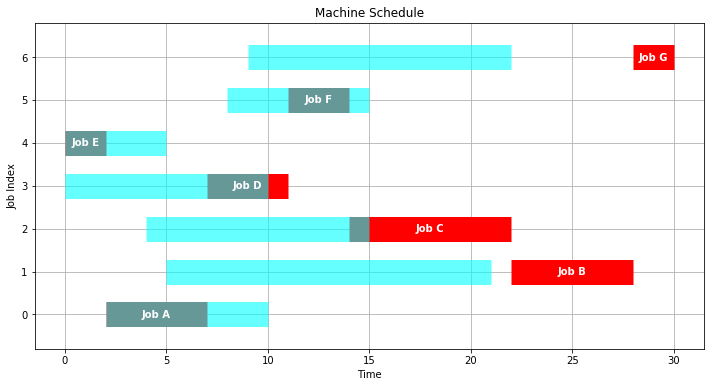

In [13]:
# objective function
m.setObjective(maxpastdue,GRB.MINIMIZE)
m.optimize()
visualize()